# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
# from xhistogram.xarray import histogram

In [2]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

In [3]:
# from dask.distributed import Client

In [4]:
# client = Client(n_workers=1, threads_per_worker=8, memory_limit=48e9)
# client

_(Click on the link above if you want to see the Dask cluster in action.)_

## Set up paths and read in trajectory data

In [84]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('/data/spg_fresh_blob_202104_data/interim/')

outputPath = Path('data/interim/sumsAndMeans/')
output_data_path = project_path / outputPath

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

figure_path = Path('reports/figures/subsets/')

# output figures path
figures_path = Path("reports/figures/ColdBlob/")

# do this year-by-year because of filesizes
year = 1992
nsubsets = 32

# proportion of data in subset
subset = 1.0

In [85]:
yearstr = str(year)

In [86]:

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file =  project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 1000 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 2100000 / 2643886

# this is to compensate for not using all the particles. 1 in 10 particles selected.

max_current = 2.0

particle_section_area = max_current * osnap_subsection_length * osnap_subsection_depth / (2643886 * subset)

## Load data

### mesh and masks

In [87]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [88]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [89]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

In [90]:
lonlat

<xarray.Dataset>
Dimensions:  (dim_0: 13)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lat      (dim_0) float64 52.09 52.67 53.59 59.11 ... 57.99 57.47 57.1 56.73
    lon      (dim_0) float64 -56.16 -52.1 -49.78 -47.34 ... -12.71 -9.275 -5.77

### tracks

## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [91]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_trackends_subsets = list(sorted(Path(interim_data_path).glob(f"*{yearstr}*.nc/")))


In [92]:
print(data_trackends_subsets)

[PosixPath('/data/spg_fresh_blob_202104_data/interim/endtracks_randomvel_mxl_osnap_backwards_1992.nc')]


In [93]:
# ds = xr.concat(
#     [xr.open_dataset(store,chunks={
#         "ends": 1, "traj": 1024
#     }) for store in data_trackends_subsets],
#     dim="traj",
# )
ds = xr.concat(
    [xr.open_dataset(store) for store in data_trackends_subsets],
    dim="traj",
)

display(ds)
print(ds.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 4870604)
Dimensions without coordinates: ends, traj
Data variables: (12/16)
    trajectory       (ends, traj) float64 184.0 265.0 ... 2.643e+06 2.643e+06
    time             (ends, traj) datetime64[ns] 1992-01-03T12:00:00 ... 1989...
    lat              (ends, traj) float64 60.07 59.9 60.05 ... 55.45 31.14 55.52
    lon              (ends, traj) float64 -42.83 -44.63 -43.07 ... -79.75 -56.26
    z                (ends, traj) float64 54.53 13.31 101.0 ... 12.26 70.82
    mxl              (ends, traj) float32 25.26 54.5 87.98 ... 12.84 18.46 12.84
    ...               ...
    LabCu_is_source  (ends, traj) bool False False False ... True False True
    LC60W_is_path    (ends, traj) bool False False False ... True False False
    LCdir_is_path    (ends, traj) bool False False False ... False False True
    GulfS_is_source  (ends, traj) bool False False False ... False True False
    other_is_source  (ends, traj) bool True True True True ... False False False
    north_of_osnap   (ends, traj) bool True True True True ... False False True
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

0.642919728 GiB


In [94]:
ds.traj.shape[0]

4870604

In [95]:
ds=ds.assign({'ncount':ds.lat/ds.lat})

In [96]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 4870604)
Dimensions without coordinates: ends, traj
Data variables: (12/17)
    trajectory       (ends, traj) float64 184.0 265.0 ... 2.643e+06 2.643e+06
    time             (ends, traj) datetime64[ns] 1992-01-03T12:00:00 ... 1989...
    lat              (ends, traj) float64 60.07 59.9 60.05 ... 55.45 31.14 55.52
    lon              (ends, traj) float64 -42.83 -44.63 -43.07 ... -79.75 -56.26
    z                (ends, traj) float64 54.53 13.31 101.0 ... 12.26 70.82
    mxl              (ends, traj) float32 25.26 54.5 87.98 ... 12.84 18.46 12.84
    ...               ...
    LC60W_is_path    (ends, traj) bool False False False ... True False False
    LCdir_is_path    (ends, traj) bool False False False ... False False True
    GulfS_is_source  (ends, traj) bool False False False ... False True False
    other_is_source  (ends, traj) bool True True True True ... False False False
    north_of_osnap   (ends, traj) bool True True True True ... False False True
    ncount           (ends, traj) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

In [ ]:
ds_time = ds.isel(ends=0).groupby("time").sum()

In [ ]:
ds_time.time

### 32 subsets, run separately

In [82]:
display(ds.time.isel(ends=1))

<xarray.DataArray 'time' (traj: 4664302)>
array(['1991-06-28T07:20:00.000000000', '1991-09-22T22:30:00.000000000',
       '1991-10-06T22:40:00.000000000', ...,
       '2009-04-24T12:00:00.000000000', '2004-05-25T12:00:00.000000000',
       '2007-08-28T12:00:00.000000000'], dtype='datetime64[ns]')
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  time
    axis:           T

#### Subset tracks by OSNAP line cross longitude and depth range

In [16]:
lonRange=[-37,0]
depthRange=[0,500]
range_str = 'OsnapE_test'

In [17]:
ds = ds.where((ds.isel(ends=0).lon > lonRange[0]) & (ds.isel(ends=0).lon < lonRange[1]))
ds = ds.where((ds.isel(ends=0).z > depthRange[0]) & (ds.isel(ends=0).z < depthRange[1]))
ds = ds.dropna('traj', how='all')

#### Add density (sigma0) to variables

In [18]:
ds = ds.assign({'rho0':xr.apply_ufunc(
    sw.dens,
    ds.salt,ds.temp,0,
    dask="parallelized",
    output_dtypes=[float, ])})
ds.rho0.attrs = {'units':'kg/m3','long_name':'potential density $\rho_0$'}

#### Velocity conversions from degrees lat/lon per second to m/s

In [19]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

In [20]:
ds = ds.assign({'section_index':(ds.isel(ends=0).lon > lonlat.lon).sum(dim='dim_0')-1})

In [21]:
costheta = lonlatdiff.costheta[ds.section_index]
sintheta = lonlatdiff.sintheta[ds.section_index]

In [22]:
ds = ds.assign({'u_normal':ds.isel(ends=0).vvel_ms * costheta - 
                           ds.isel(ends=0).uvel_ms * sintheta})
ds = ds.assign({'u_along':ds.isel(ends=0).vvel_ms * sintheta + 
                          ds.isel(ends=0).uvel_ms * costheta})

#### Find along-section distances of initial points

In [23]:
ds = ds.assign({'x':xr.DataArray(length_west[ds.section_index] + lonlatdiff.length[ds.section_index]*
                              (ds.isel(ends=0).lon - lonlat.lon[ds.section_index])/lonlatdiff.lon[ds.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [24]:
# at osnap line
ds = ds.assign({'vol_trans_normal':np.sign(ds.u_normal) * particle_section_area/1.0e06})
ds = ds.assign({'particle_vol':ds.vol_trans_normal/ds.u_normal})

In [25]:
# at osnap line
ds = ds.assign({'temp_transport':ds.temp * ds.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds.vol_trans_normal})
ds = ds.assign({'depth_transport':ds.z * ds.vol_trans_normal})
ds = ds.assign({'lon_transport':ds.lon * ds.vol_trans_normal})
ds = ds.assign({'tempxvol':ds.temp * ds.particle_vol})
ds = ds.assign({'saltxvol':ds.salt * ds.particle_vol})
ds = ds.assign({'depthxvol':ds.z * ds.particle_vol})
ds = ds.assign({'lonxvol':ds.lon * ds.particle_vol})


In [26]:
ds

<xarray.Dataset>
Dimensions:           (ends: 2, traj: 2367478)
Coordinates:
    dim_0             (traj) int64 6 6 6 6 6 6 6 6 6 ... 12 12 12 12 12 12 12 12
Dimensions without coordinates: ends, traj
Data variables: (12/33)
    trajectory        (ends, traj) float64 1.826e+05 1.827e+05 ... 2.644e+06
    time              (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 198...
    lat               (ends, traj) float64 59.06 59.12 59.13 ... 54.77 30.76
    lon               (ends, traj) float64 -33.04 -33.59 ... -54.71 -79.61
    z                 (ends, traj) float64 462.4 238.4 412.4 ... 93.01 204.5
    mxl               (ends, traj) float32 296.1 276.1 270.4 ... 24.83 21.39
    ...                ...
    depth_transport   (ends, traj) float64 0.831 0.4285 0.7411 ... 0.1672 0.3675
    lon_transport     (ends, traj) float64 -0.05939 -0.06038 ... -0.1431
    tempxvol          (ends, traj) float64 0.1269 0.05373 ... -0.005965 0.08136
    saltxvol          (ends, traj) float64 0.6589 0.2639 ... 0.3949 0.1599
    depthxvol         (ends, traj) float64 8.676 1.794 4.49 ... 1.092 0.8992
    lonxvol           (ends, traj) float64 -0.62 -0.2528 ... -0.6424 -0.3501
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

## Plot section

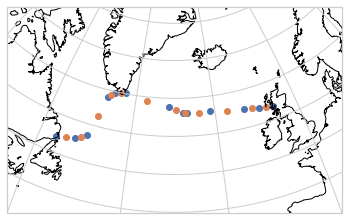

In [27]:
sns.set(style="whitegrid")
central_lon, central_lat = -30, 55
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
extent = [-60, 0, 40, 70]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

lonlat.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat')
lonlat2mean.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat');

In [28]:
total_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
total_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [29]:
labcu_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
labcu_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [30]:
gulfs_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
gulfs_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [31]:
other_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).other_is_source)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
other_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).other_is_source)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [32]:
lc60w_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lc60w_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [33]:
lcdir_sum_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby("time").sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lcdir_mean_0 = xr.concat(
    [ds.isel(ends=0,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby("time").mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [34]:
total_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
total_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [35]:
labcu_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
labcu_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [36]:
gulfs_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
gulfs_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [37]:
other_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).other_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
other_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).other_is_source)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [38]:
lc60w_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lc60w_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [39]:
lcdir_sum_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).sum() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
lcdir_mean_1 = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).time).mean() 
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

### group by times at source

In [40]:
starttime = np.datetime64('1980-01-01T00:00')
deltat = np.timedelta64(5,'D')
times = np.array([starttime + i * deltat for i in range(2923)])

In [41]:
total_sum_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .groupby_bins("time",times).sum() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)
total_mean_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .groupby_bins("time",times).mean() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)

In [42]:
labcu_sum_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby_bins("time",times).sum() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)
labcu_mean_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LabCu_is_source)
       .groupby_bins("time",times).mean() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)

In [43]:
gulfs_sum_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby_bins("time",times).sum() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)
gulfs_mean_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).GulfS_is_source)
       .groupby_bins("time",times).mean() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)

In [44]:
other_sum_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).other_is_source)
       .groupby_bins("time",times).sum()
       for subsetno in range(0,nsubsets)],
    dim="subsetno",
)
other_mean_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).other_is_source)
       .groupby_bins("time",times).mean() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [45]:
lc60w_sum_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby_bins("time",times).sum() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)
lc60w_mean_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LC60W_is_path)
       .groupby_bins("time",times).mean() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)

In [46]:
lcdir_sum_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby_bins("time",times).sum() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)
lcdir_mean_sourcetime = xr.concat(
    [ds.isel(ends=1,traj=slice(subsetno,None,nsubsets))
       .where(ds.isel(ends=0,traj=slice(subsetno,None,nsubsets)).LCdir_is_path)
       .groupby_bins("time",times).mean() 
       for subsetno in range(0,nsubsets)],
    dim="subsetno"
)

In [1]:
time_mid = [v.mid for v in total_sum_sourcetime.time_bins.values]
total_sum_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in labcu_sum_sourcetime.time_bins.values]
labcu_sum_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in gulfs_sum_sourcetime.time_bins.values]
gulfs_sum_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in other_sum_sourcetime.time_bins.values]
other_sum_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in lcdir_sum_sourcetime.time_bins.values]
lcdir_sum_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in lc60w_sum_sourcetime.time_bins.values]
lc60w_sum_sourcetime["time_bins"]=time_mid


NameError: name 'total_sum_sourcetime' is not defined

In [65]:
time_mid = [v.mid for v in total_mean_sourcetime.time_bins.values]
total_mean_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in labcu_mean_sourcetime.time_bins.values]
labcu_mean_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in gulfs_mean_sourcetime.time_bins.values]
gulfs_mean_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in other_mean_sourcetime.time_bins.values]
other_mean_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in lcdir_mean_sourcetime.time_bins.values]
lcdir_mean_sourcetime["time_bins"]=time_mid
time_mid = [v.mid for v in lc60w_mean_sourcetime.time_bins.values]
lc60w_mean_sourcetime["time_bins"]=time_mid


(0.0, 22.150788552042652)

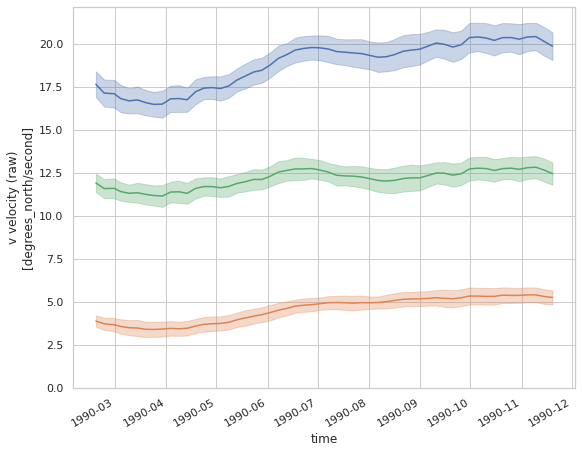

In [52]:
fig,ax = plt.subplots(1,figsize = (9,7),sharex=True)

# for i in range(16):
#     (16*total_sum_0.isel(subsetno=i).vol_trans_normal).plot(ax=ax,alpha=0.4,zorder=1)

total_sum_rolling = (total_sum_0.vol_trans_normal.sum(dim='subsetno')
                                                 .rolling(time=18,center=True).mean())
total_sum_rolling.plot(ax=ax,
                       color='C0',
                       zorder=10)
std = ((32*total_sum_0.vol_trans_normal.rolling(time=18,center=True).mean())
                                       .std(dim='subsetno'))
ax.fill_between(total_sum_0.time.data,
                total_sum_rolling+1.96*std,
                total_sum_rolling-1.96*std,
                color='C0',
                zorder=1,
                alpha=0.3)

labcu_sum_rolling = (labcu_sum_0.vol_trans_normal.sum(dim='subsetno')
                                                 .rolling(time=18,center=True).mean())
labcu_sum_rolling.plot(ax=ax,
                       color='C1',
                       zorder=10)
std = ((32*labcu_sum_0.vol_trans_normal.rolling(time=18,center=True).mean())
                                       .std(dim='subsetno'))
ax.fill_between(labcu_sum_0.time.data,
                labcu_sum_rolling+1.96*std,
                labcu_sum_rolling-1.96*std,
                color='C1',
                zorder=1,
                alpha=0.3)

gulfs_sum_rolling = (gulfs_sum_0.vol_trans_normal.sum(dim='subsetno')
                                                 .rolling(time=18,center=True).mean())
gulfs_sum_rolling.plot(ax=ax,
                       color='C2',
                       zorder=10)
std = ((32*gulfs_sum_0.vol_trans_normal.rolling(time=18,center=True).mean())
                                       .std(dim='subsetno'))
ax.fill_between(gulfs_sum_0.time.data,
                gulfs_sum_rolling+1.96*std,
                gulfs_sum_rolling-1.96*std,
                color='C2',
                zorder=1,
                alpha=0.3)

ax.set_ylim(0)

(0.0, 6.215580076242692)

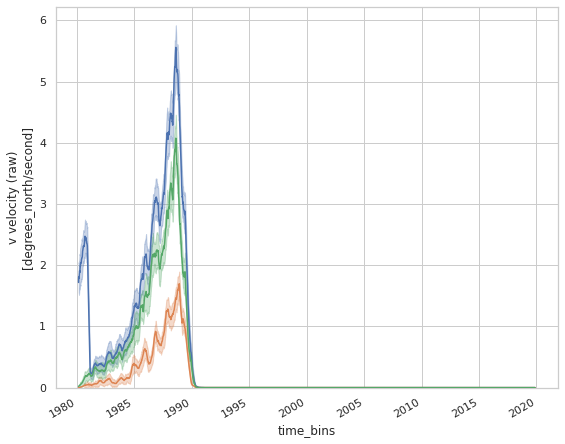

In [51]:
fig,ax = plt.subplots(1,figsize = (9,7),sharex=True)

total_sum_rolling = (total_sum_sourcetime.vol_trans_normal.sum(dim='subsetno')
                                         .rolling(time_bins=18,center=True).mean())
total_sum_rolling.plot(ax=ax,color='C0',zorder=10)
std = ((32*total_sum_sourcetime.vol_trans_normal.rolling(time_bins=18,center=True).mean())
                               .std(dim='subsetno'))
ax.fill_between(total_sum_sourcetime.time_bins.data,
                total_sum_rolling+1.96*std,
                total_sum_rolling-1.96*std,
                color='C0',
                zorder=1,
                alpha=0.3)

labcu_sum_rolling = (labcu_sum_sourcetime.vol_trans_normal.sum(dim='subsetno')
                                         .rolling(time_bins=18,center=True).mean())
labcu_sum_rolling.plot(ax=ax,color='C1',zorder=10)
std = ((32*labcu_sum_sourcetime.vol_trans_normal.rolling(time_bins=18,center=True).mean())
                               .std(dim='subsetno'))
ax.fill_between(labcu_sum_sourcetime.time_bins.data,
                labcu_sum_rolling+1.96*std,
                labcu_sum_rolling-1.96*std,
                color='C1',
                zorder=1,
                alpha=0.3)

gulfs_sum_rolling = (gulfs_sum_sourcetime.vol_trans_normal.sum(dim='subsetno')
                                         .rolling(time_bins=18,center=True).mean())
gulfs_sum_rolling.plot(ax=ax,color='C2',zorder=10)
std = ((32*gulfs_sum_sourcetime.vol_trans_normal.rolling(time_bins=18,center=True).mean())
                               .std(dim='subsetno'))
ax.fill_between(gulfs_sum_sourcetime.time_bins.data,
                gulfs_sum_rolling+1.96*std,
                gulfs_sum_rolling-1.96*std,
                color='C2',
                zorder=1,
                alpha=0.3)

ax.set_ylim(0)

In [58]:
total_sum_0.to_netcdf(output_data_path / str('total_sum_0_'+yearstr+'.nc'))
labcu_sum_0.to_netcdf(output_data_path / str('labcu_sum_0_'+yearstr+'.nc'))
gulfs_sum_0.to_netcdf(output_data_path / str('gulfs_sum_0_'+yearstr+'.nc'))
other_sum_0.to_netcdf(output_data_path / str('other_sum_0_'+yearstr+'.nc'))
lcdir_sum_0.to_netcdf(output_data_path / str('lcdir_sum_0_'+yearstr+'.nc'))
lc60w_sum_0.to_netcdf(output_data_path / str('lc60w_sum_0_'+yearstr+'.nc'))


In [59]:
total_mean_0.to_netcdf(output_data_path / str('total_mean_0_'+yearstr+'.nc'))
labcu_mean_0.to_netcdf(output_data_path / str('labcu_mean_0_'+yearstr+'.nc'))
gulfs_mean_0.to_netcdf(output_data_path / str('gulfs_mean_0_'+yearstr+'.nc'))
other_mean_0.to_netcdf(output_data_path / str('other_mean_0_'+yearstr+'.nc'))
lcdir_mean_0.to_netcdf(output_data_path / str('lcdir_mean_0_'+yearstr+'.nc'))
lc60w_mean_0.to_netcdf(output_data_path / str('lc60w_mean_0_'+yearstr+'.nc'))


In [60]:
total_sum_1.to_netcdf(output_data_path / str('total_sum_1_'+yearstr+'.nc'))
labcu_sum_1.to_netcdf(output_data_path / str('labcu_sum_1_'+yearstr+'.nc'))
gulfs_sum_1.to_netcdf(output_data_path / str('gulfs_sum_1_'+yearstr+'.nc'))
other_sum_1.to_netcdf(output_data_path / str('other_sum_1_'+yearstr+'.nc'))
lcdir_sum_1.to_netcdf(output_data_path / str('lcdir_sum_1_'+yearstr+'.nc'))
lc60w_sum_1.to_netcdf(output_data_path / str('lc60w_sum_1_'+yearstr+'.nc'))


In [61]:
total_mean_1.to_netcdf(output_data_path / str('total_mean_1_'+yearstr+'.nc'))
labcu_mean_1.to_netcdf(output_data_path / str('labcu_mean_1_'+yearstr+'.nc'))
gulfs_mean_1.to_netcdf(output_data_path / str('gulfs_mean_1_'+yearstr+'.nc'))
other_mean_1.to_netcdf(output_data_path / str('other_mean_1_'+yearstr+'.nc'))
lcdir_mean_1.to_netcdf(output_data_path / str('lcdir_mean_1_'+yearstr+'.nc'))
lc60w_mean_1.to_netcdf(output_data_path / str('lc60w_mean_1_'+yearstr+'.nc'))


In [62]:
total_sum_sourcetime.to_netcdf(output_data_path / str('total_sum_sourcetime_'+yearstr+'.nc'))
labcu_sum_sourcetime.to_netcdf(output_data_path / str('labcu_sum_sourcetime_'+yearstr+'.nc'))
gulfs_sum_sourcetime.to_netcdf(output_data_path / str('gulfs_sum_sourcetime_'+yearstr+'.nc'))
other_sum_sourcetime.to_netcdf(output_data_path / str('other_sum_sourcetime_'+yearstr+'.nc'))
lcdir_sum_sourcetime.to_netcdf(output_data_path / str('lcdir_sum_sourcetime_'+yearstr+'.nc'))
lc60w_sum_sourcetime.to_netcdf(output_data_path / str('lc60w_sum_sourcetime_'+yearstr+'.nc'))


In [66]:
total_mean_sourcetime.to_netcdf(output_data_path / str('total_mean_sourcetime_'+yearstr+'.nc'))
labcu_mean_sourcetime.to_netcdf(output_data_path / str('labcu_mean_sourcetime_'+yearstr+'.nc'))
gulfs_mean_sourcetime.to_netcdf(output_data_path / str('gulfs_mean_sourcetime_'+yearstr+'.nc'))
other_mean_sourcetime.to_netcdf(output_data_path / str('other_mean_sourcetime_'+yearstr+'.nc'))
lcdir_mean_sourcetime.to_netcdf(output_data_path / str('lcdir_mean_sourcetime_'+yearstr+'.nc'))
lc60w_mean_sourcetime.to_netcdf(output_data_path / str('lc60w_mean_sourcetime_'+yearstr+'.nc'))


In [ ]:
conda list